# Hyperparamètres, LassoRandomForestRregressor et grid_search (correction)

Le notebook explore l'optimisation des hyper paramaètres du modèle [LassoRandomForestRegressor](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/ensae_teaching_cs/ml/lasso_random_forest_regressor.html), et fait varier le nombre d'arbre et le paramètres alpha.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [17]:
%matplotlib inline

## Données

In [3]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Premiers modèles

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
r2_score(y_test, rf.predict(X_test))

C:\Users\Mayeul Picard\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8122029348213134

In [5]:
import numpy
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso


class LassoRandomForestRegressor(BaseEstimator, RegressorMixin):
    """
    Fits a random forest and then selects trees by using a
    Lasso regression. The traning produces the following
    attributes:
    * `rf_estimator_`: trained random forest
    * `lasso_estimator_`: trained Lasso
    * `estimators_`: trained estimators mapped to a not null coefficients
    * `intercept_`: bias
    * `coef_`: estimators weights
    """

    def __init__(self, rf_estimator=None, lasso_estimator=None):
        """
        @param  rf_estimator    random forest estimator,
                                :epkg:`sklearn:ensemble:RandomForestRegressor`
                                by default
        @param  lass_estimator  Lasso estimator,
                                :epkg:`sklearn:linear_model:LassoRegression`
                                by default
        """
        BaseEstimator.__init__(self)
        RegressorMixin.__init__(self)
        if rf_estimator is None:
            rf_estimator = RandomForestRegressor()
        if lasso_estimator is None:
            lasso_estimator = Lasso()
        self.rf_estimator = rf_estimator
        self.lasso_estimator = lasso_estimator

    def fit(self, X, y, sample_weight=None):
        """
        Fits the random forest first, then applies a lasso
        and finally removes all trees mapped to a null coefficient.
        @param      X               training features
        @param      y               training labels
        @param      sample_weight   sample weights
        """
        self.rf_estimator_ = clone(self.rf_estimator)
        self.rf_estimator_.fit(X, y, sample_weight)

        estims = self.rf_estimator_.estimators_
        estimators = numpy.array(estims).ravel()
        X2 = numpy.zeros((X.shape[0], len(estimators)))
        for i, est in enumerate(estimators):
            pred = est.predict(X)
            X2[:, i] = pred

        self.lasso_estimator_ = clone(self.lasso_estimator)
        self.lasso_estimator_.fit(X2, y)

        not_null = self.lasso_estimator_.coef_ != 0
        self.intercept_ = self.lasso_estimator_.intercept_
        self.estimators_ = estimators[not_null]
        self.coef_ = self.lasso_estimator_.coef_[not_null]
        return self

    def decision_function(self, X):
        """
        Computes the predictions.
        """
        prediction = None
        for i, est in enumerate(self.estimators_):
            pred = est.predict(X)
            if prediction is None:
                prediction = pred * self.coef_[i]
            else:
                prediction += pred * self.coef_[i]
        return prediction + self.intercept_

    def predict(self, X):
        """
        Computes the predictions.
        """
        return self.decision_function(X)

Pour le modèle, il suffit de copier coller le code écrit dans ce fichier [lasso_random_forest_regressor.py](https://github.com/sdpython/ensae_teaching_cs/blob/master/src/ensae_teaching_cs/ml/lasso_random_forest_regressor.py).

In [6]:
# from ensae_teaching_cs.ml.lasso_random_forest_regressor import LassoRandomForestRegressor
lrf = LassoRandomForestRegressor()
lrf.fit(X_train, y_train)
r2_score(y_test, lrf.predict(X_test))

C:\Users\Mayeul Picard\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7774417235280571

Le modèle a réduit le nombre d'arbres.

In [7]:
len(lrf.estimators_)

10

## Grid Search

On veut trouver la meilleure paire de paramètres (``n_estimators``, ``alpha``). *scikit-learn* implémente l'objet [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) qui effectue de nombreux apprentissage avec toutes les valeurs de paramètres qu'il reçoit. Voici tous les paramètres qu'on peut changer :

In [8]:
lrf.get_params()

{'lasso_estimator__alpha': 1.0,
 'lasso_estimator__copy_X': True,
 'lasso_estimator__fit_intercept': True,
 'lasso_estimator__max_iter': 1000,
 'lasso_estimator__normalize': False,
 'lasso_estimator__positive': False,
 'lasso_estimator__precompute': False,
 'lasso_estimator__random_state': None,
 'lasso_estimator__selection': 'cyclic',
 'lasso_estimator__tol': 0.0001,
 'lasso_estimator__warm_start': False,
 'lasso_estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 'rf_estimator__bootstrap': True,
 'rf_estimator__criterion': 'mse',
 'rf_estimator__max_depth': None,
 'rf_estimator__max_features': 'auto',
 'rf_estimator__max_leaf_nodes': None,
 'rf_estimator__min_impurity_decrease': 0.0,
 'rf_estimator__min_impurity_split': None,
 'rf_estimator__min_samples_leaf': 1,
 'rf_estimator__min_samples_split': 2,
 'rf_estimator__min_weig

In [9]:
params = {
    'lasso_estimator__alpha': [0.25, 0.5, 0.75, 1., 1.25, 1.5],
    'rf_estimator__n_estimators': [20, 40, 60, 80, 100, 120]
}

In [10]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid = GridSearchCV(estimator=LassoRandomForestRegressor(),
                    param_grid=params, verbose=1)
grid.fit(X_train, y_train)

C:\Users\Mayeul Picard\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   15.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LassoRandomForestRegressor(lasso_estimator=Lasso(alpha=1.0,
                                                                        copy_X=True,
                                                                        fit_intercept=True,
                                                                        max_iter=1000,
                                                                        normalize=False,
                                                                        positive=False,
                                                                        precompute=False,
                                                                        random_state=None,
                                                                        selection='cyclic',
                                                                        tol=0.0001,
                                                              

Les meilleurs paramètres sont les suivants :

In [11]:
grid.best_params_

{'lasso_estimator__alpha': 0.25, 'rf_estimator__n_estimators': 40}

Et le modèle a gardé un nombre réduit d'arbres :

In [12]:
len(grid.best_estimator_.estimators_)

28

In [13]:
r2_score(y_test, grid.predict(X_test))

0.7796908243606574

## Evolution de la performance en fonction des paramètres

In [14]:
grid.cv_results_

{'mean_fit_time': array([0.0418992 , 0.07845577, 0.13197811, 0.16356214, 0.19880152,
        0.2376972 , 0.04022479, 0.07978646, 0.11735193, 0.16489228,
        0.19647392, 0.23570307, 0.04055738, 0.07846697, 0.11866919,
        0.16489212, 0.19979811, 0.24135248, 0.03956   , 0.07646139,
        0.12333679, 0.16888118, 0.20245767, 0.23902655, 0.04554439,
        0.07579764, 0.1256632 , 0.15857514, 0.20212523, 0.23869411,
        0.04022503, 0.07579692, 0.11801759, 0.1572454 , 0.20445267,
        0.24301577]),
 'std_fit_time': array([0.00216011, 0.00463825, 0.00950659, 0.00802005, 0.00529872,
        0.00169547, 0.00204882, 0.00282103, 0.00622031, 0.00094027,
        0.0037314 , 0.00329103, 0.00047002, 0.00307222, 0.00668275,
        0.00835792, 0.00417842, 0.0035497 , 0.00169514, 0.00235022,
        0.00409883, 0.00611129, 0.00508542, 0.00448529, 0.00261785,
        0.00081546, 0.01264146, 0.00141012, 0.00803367, 0.00497579,
        0.00261773, 0.00215439, 0.00204883, 0.00497539, 0.009

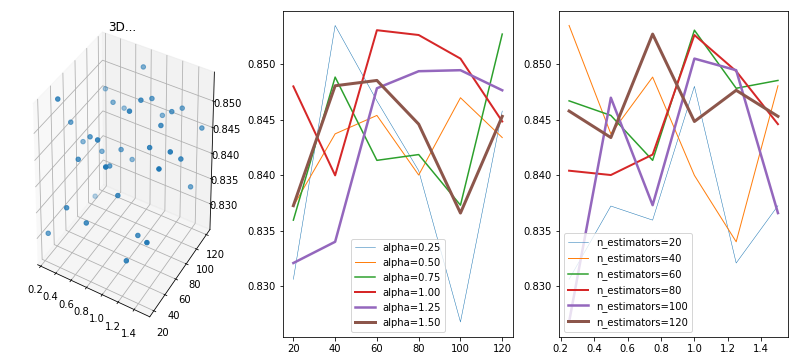

In [18]:
import numpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131, projection='3d')
xs = numpy.array([el['lasso_estimator__alpha'] for el in grid.cv_results_['params']])
ys = numpy.array([el['rf_estimator__n_estimators'] for el in grid.cv_results_['params']])
zs = numpy.array(grid.cv_results_['mean_test_score'])
ax.scatter(xs, ys, zs)
ax.set_title("3D...")

ax = fig.add_subplot(132)
for x in sorted(set(xs)):
    y2 = ys[xs == x]
    z2 = zs[xs == x]
    ax.plot(y2, z2, label="alpha=%1.2f" % x, lw=x*2)
ax.legend();

ax = fig.add_subplot(133)
for y in sorted(set(ys)):
    x2 = xs[ys == y]
    z2 = zs[ys == y]
    ax.plot(x2, z2, label="n_estimators=%d" % y, lw=y/40)
ax.legend();

Il semble que la valeur de alpha importe peu mais qu'un grand nombre d'arbres a un impact positif. Cela dit, il faut ne pas oublier l'écart-type de ces variations qui n'est pas négligeable.

In [16]:
plt.show()